## CHAPTER 11
---
# MODEL EVALUATION

---
- In this chapter we will examine strategies for evaluating the quality of models created through our learning algorithms. 
- It might appear strange to discuss model evaluation before discussing how to create them, but there is a method to our madness. 
- Models are only as useful as the quality of their predictions, and thus fundamentally our goal is not to create models (which is easy) but to create high-quality models (which is hard). 
- Therefore, before we explore the myriad learning algorithms, we first set up how we can evaluate the models they produce.

## 11.1 Cross-Validating Models
**Problem:** we want to evaluate how well our model will work in the real world

**Solution:** we will create a pipeline that
- preprocesses the data, 
- trains the model, and then 
- evaluates it using cross-validation

In [1]:
# Load libraries
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# load digits dataset
digits = datasets.load_digits()

# create features matrix
features = digits.data

# create target vector
target = digits.target

# create standardizer
standardizer = StandardScaler()

# create logitic regression object
logit = LogisticRegression()

# create a pipeline that standardizes, then runs logistic regression
pipeline = make_pipeline(standardizer, logit)

# create k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# conduct k-fold cross-validation
cv_results = cross_val_score(pipeline, # Pipeline
                             features, # feature matrix
                             target, # target vector
                             cv=kf, # cross-validation technique,
                             scoring="accuracy", # loss function
                             n_jobs=-1) # use all CPU cores

# calculate mean
cv_results.mean()

0.9693916821849783

### Discussion:
- Our goal is to evaluate how well our model does on data it has never seen before (e.g., a new customer, a new crime, a new image). 
- **The validation approach:**
    - split data into training set and test set
    - set the test set aside and pretend it's never been seen before
    - train the model on the training set and teach it how to make the best predictions
    - evaluate the model on the testing set and see how it does
- The two major weaknesses of the validation approach:
    - the performance of the model can be highly dependent on which few observations were selected for the test set. 
    - Second, the model is not being trained using all the available data, and not being evaluated on all the available data.
- **The k-fold cross-validation (KFCV) strategy:**
    - data is split into k parts, called "*folds*"
    - the model is trained using k-1 folds, combined as a training set
    - the last fold is used as a test set
    - this is repeated k times each time using a different fold as the test set. 
    - The performance on the model for each of the k iterations is then averaged to produce an overall measurement.

In [2]:
cv_results

array([0.97777778, 0.98888889, 0.96111111, 0.94444444, 0.97777778,
       0.98333333, 0.95555556, 0.98882682, 0.97765363, 0.93854749])

- KFCV assumes that each observation was created independent from the other, if so it is a good idea to shuffle observations which can be done in scikit-learn by setting shuffle=True.
- When using KFCV to evaluate a classifier, it is often beneficial to perform *stratified k-fold* by replacing KFold class with StratifiedKFold. 
- When using validation sets or cross-validation, it is important to preprocess data based on the training set and then apply those transformations to both the training and test set. The reason is
    - we are pretending that the test set is unknown data
    - it prevents the leaking of information from test set into the training set

In [3]:
# Import library
from sklearn.model_selection import train_test_split

# Create training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# Fit standardizer to training set
standardizer.fit(features_train)

# Apply to both training and test sets
features_train_std = standardizer.transform(features_train)
features_test_std = standardizer.transform(features_test)

# Create a pipeline
pipeline = make_pipeline(standardizer, logit)

# Do k-fold cross-validation
cv_results = cross_val_score(pipeline, # Pipeline
                             features, # Feature matrix
                             target, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores
cv_results

array([0.97777778, 0.98888889, 0.96111111, 0.94444444, 0.97777778,
       0.98333333, 0.95555556, 0.98882682, 0.97765363, 0.93854749])

Cross_val_score parameters:
- cv determines our cross-validation technique. K-fold is the most common by far
- the scoring parameter defines our metric for success
- n_jobs=-1 tells scikit-learn to use every core of the computer available to speed up the operation

## 11.2 Creating a Baseline Regression Model

**Problem:** we want a simple baseline regression model to compare against our model.

**Solution:** use scikit-learn’s DummyRegressor to create a simple model to use as a baseline

In [4]:
# Load libraries
from sklearn.datasets import load_boston
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

# Load data
boston = load_boston()

# Create features
features, target = boston.data, boston.target

# Make test and training split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=0)

# Create a dummy regressor
dummy = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy.fit(features_train, target_train)

# Get R-squared score
dummy.score(features_test, target_test)

-0.001119359203955339

To compare, we train our model and evaluate the performance score

In [5]:
# Load library
from sklearn.linear_model import LinearRegression

# Train simple linear regression model
ols = LinearRegression()
ols.fit(features_train, target_train)

# Get R-squared score
ols.score(features_test, target_test)

0.6354638433202129

## 11.3 Creating a Baseline Classification Model

**Problem:** You want a simple baseline classifier to compare against your model.

**Solution:** Use scikit-learn’s DummyClassifier

In [6]:
# Load libraries
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# Load data
iris = load_iris()

# Create target vector and feature matrix
features, target = iris.data, iris.target

# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(
features, target, random_state=0)

# Create dummy classifier
dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(features_train, target_train)

# Get accuracy score
dummy.score(features_test, target_test)

0.42105263157894735

By comparing the baseline classifier to our trained classifier, we can see the improvement

In [7]:
# Load library
from sklearn.ensemble import RandomForestClassifier

# Create classifier
classifier = RandomForestClassifier()

# Train model
classifier.fit(features_train, target_train)

# Get accuracy score
classifier.score(features_test, target_test)

0.9736842105263158

- A common measure of a classifier’s performance is how much better it is than random guessing. scikit-learn’s DummyClassifier makes this comparison easy. 
- The strategy parameter gives us a number of options for generating values. There are two strategies. 
    - *stratified* makes predictions that are proportional to the training set’s target vector’s class proportions 
    - *uniform* will generate predictions uniformly at random between the different classes. 

## 11.4 Evaluating Binary Classifier Predictions

**Problem:** Given a trained classification model, you want to evaluate its quality.

**Solution:** Use scikit-learn’s cross_val_score to conduct cross-validation while using the scoring parameter to define one of a number of performance metrics, including accuracy, precision, recall, and F1.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# generate features matrix and target vector
X, y = make_classification(n_samples = 10000,
                           n_features = 3,
                           n_informative = 3,
                           n_redundant = 0,
                           n_classes = 2,
                           random_state = 1)
# create logistic regression
logit = LogisticRegression()

# cross-validate model using accuracy
cross_val_score(logit, X, y, scoring='accuracy')

array([0.9555, 0.95  , 0.9585, 0.9555, 0.956 ])

In [9]:
# Cross-validate model using precision
cross_val_score(logit, X, y, scoring="precision")

array([0.95963673, 0.94820717, 0.9635996 , 0.96149949, 0.96060606])

In [10]:
# Cross-validate model using recall
cross_val_score(logit, X, y, scoring="recall")

array([0.951, 0.952, 0.953, 0.949, 0.951])

In [11]:
# Cross-validate model using f1
cross_val_score(logit, X, y, scoring="f1")

array([0.95529884, 0.9500998 , 0.95827049, 0.95520886, 0.95577889])

- We can measure accuracy in 5-fold (the default number of folds) cross-validation by setting scoring="accuracy"
- Models with high precision are pessimistic in that they only predict an observation is of the positive class when they are very certain about it.
- Models with high recall are optimistic in that they have a low bar for predicting that an observation is in the positive class
- The F1 score is the harmonic mean (a kind of average used for ratios). It is a measure of correctness achieved in positive prediction—that is, of observations labeled as positive, how many are actually positive.

Alternatively to using cross_val_score, if we already have the true y values and the predicted y values, we can calculate metrics like accuracy and recall directly:

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Predict values for training target vector
y_hat = logit.fit(X_train, y_train).predict(X_test)

# Calculate accuracy
accuracy_score(y_test, y_hat)

0.947

## 11.5 Evaluating Binary Classifier Thresholds

**Problem:** You want to evaluate a binary classifier and various probability thresholds.

**Solution:** The Receiving Operating Characteristic (ROC) curve is a common method for evaluating the quality of a binary classifier. 

In scikit-learn, we can use roc_curve to calculate the true and false positives at each threshold, then plot them:

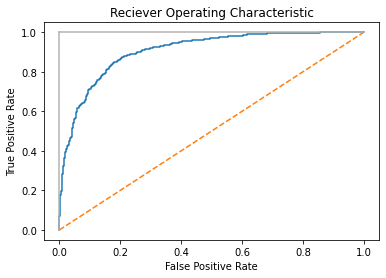

In [13]:

# load libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# create feature matrix and target vector
features, target = make_classification(n_samples=10000,
                                       n_features=10,
                                       n_classes=2,
                                       n_informative=3,
                                       random_state=3)
# split into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=1)

# create classifier
logit = LogisticRegression()

# train model
logit.fit(features_train, target_train)

# get predicted probabilities
target_probabilities = logit.predict_proba(features_test)[:,1]

# create true and positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test, target_probabilities)

# plot ROC curve
plt.title("Reciever Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1,0], c=".7") 
plt.plot([1, 1], c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

- ROC compares the presence of true positives and false positives at every probability threshold (i.e., the probability at which an observation is predicted to be a class). 
- By plotting the ROC curve, we can see how the model performs. 
    - A classifier that predicts every observation correctly would look like the solid light gray line in the chart above, going straight up to the top immediately. 
    - A classifier that predicts at random will appear as the diagonal line. 
    - The better the model, the closer it is to the solid line.     

#### Discussion:
- Up until now we have only examined models based on the values they predict. 
- However, in many learning algorithms those predicted values are based off of probability estimates. 
- In our solution, we can use predict_proba to see the predicted probabilities for the first observation

In [14]:
# Get predicted probabilities
logit.predict_proba(features_test)[0:1]

array([[0.87094106, 0.12905894]])

In [15]:
# We can see the probability classes
logit.classes_

array([0, 1])

In this example, the first observation has an ~87% chance of being in the negative class (0) and a 13% chance of being in the positive class (1)

**Threshold:** By default, scikit-learn predicts an observation is part of the positive class if the probability is greater than 0.5
- However, instead of a middle ground, we will often want to explicitly bias our model to use a different threshold for substantive reasons: false positive or false negative, which one to avoid the most?
- The prediction trade-off is represented by the true positive rate (TPR) and the false positive rate (FPR)
- The ROC curve represents the respective TPR and FPR for every probability threshold. 
- Let's examine the threshold values and see what happens to TPR and FPR when we change the threshold

In [16]:
# from Innocent, not in book
threshold[240:260]

array([0.52006024, 0.51901229, 0.51469154, 0.51464729, 0.51192875,
       0.50977873, 0.50556537, 0.50265506, 0.50208102, 0.5016343 ,
       0.50068825, 0.49922991, 0.49273392, 0.49237501, 0.49226661,
       0.49224401, 0.49221264, 0.4882918 , 0.484656  , 0.48362505])

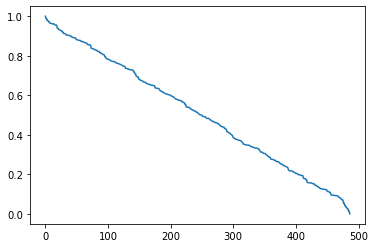

In [17]:
# from Innocent, not in book
# excluding the first value, which is 2
plt.plot(threshold[1:])

In our solution a threshold of roughly 0.50 has a TPR of ~0.84 and an FPR of ~0.18

In [18]:
print("Threshold: {}".format(threshold[250]))
print("True Positive Rate: {}".format(true_positive_rate[250]))
print("False Positive Rate: {}".format(false_positive_rate[250]))

Threshold: 0.5006882519902771
True Positive Rate: 0.839518555667001
False Positive Rate: 0.1744765702891326


However, if we increase the threshold to ~80% (i.e., increase how certain the model has to be before it predicts an observation as positive) the TPR drops significantly but so does the FPR. This is because our higher requirement for being predicted to be in the positive class has made the model not identify a number of positive observations (the lower TPR), but also reduce the noise from negative observations being predicted as positive (the lower FPR).

In [19]:
print("Threshold: {}".format(threshold[95]))
print("True Positive Rate: {}".format(true_positive_rate[95]))
print("False Positive Rate: {}".format(false_positive_rate[95]))

Threshold: 0.8043803686853731
True Positive Rate: 0.567703109327984
False Positive Rate: 0.05284147557328016


It is often common to calculate the area under the ROC curve (AUCROC) to judge the overall quality of a model at all possible thresholds. The better a model is, the higher the curve and thus the greater the area under the curve.

In [20]:
# Calculate area under curve
roc_auc_score(target_test, target_probabilities)

0.9060171541543875

## 11.6 Evaluating Multiclass Classifier Predictions

**Problem:** You have a model that predicts three or more classes and want to evaluate its performance.

**Solution:** Use cross-validation with an evaluation metric capable of handling more than two classes.

In [21]:
# load libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# generate features matrix and target vector
features, target = make_classification(n_samples=10000,
                                       n_features=3,
                                       n_informative=3,
                                       n_redundant=0,
                                       n_classes=3,
                                       random_state=1)
# create logistic regression
logit = LogisticRegression()

# cross-validate model using accuracy
cross_val_score(logit, features, target, scoring='accuracy')

array([0.841 , 0.829 , 0.8265, 0.8155, 0.82  ])

#### Discussion:
- When we have balanced classes (e.g. a roughly equal number of observations in each class of a target vector), accuracy is--just like in the binary class setting--a simple and interpretable choce for an evaluation metric. 
    - Accuracy is the number of correct predictions divided by the number of observations and works just as well in the multiclass as binary setting. 
- However, when we have imbalanced classes (a common scenario), we should be inclined to use other evaluation metrics.
    - Precision, recall, and F1 scores are useful metrics. 
    - While all of them were originally designed for binary classifiers, we can apply them to multiclass settings by treating our data as a set of binary classes. 
    - Doing so enables us to apply the metrics to each class as if it were the only class in the data, and then aggregate the evaluation scores for all the classes by averaging them

In [22]:
# Cross-validate model using macro averaged F1 score
cross_val_score(logit, features, target, scoring='f1_macro')

array([0.84061272, 0.82895312, 0.82625661, 0.81515121, 0.81992692])

Methods used to average the evaluation scores from the classes:
- **macro:** Calculate mean of metric scores for each class, weighting each class equally.
- **weighted:** Calculate mean of metric scores for each class, weighting each class proportional to its size in the data.
- **micro:** Calculate mean of metric scores for each observation-class combination.

In [23]:
# Cross-validate model using macro averaged F1 score
cross_val_score(logit, features, target, scoring='f1_weighted')

array([0.84063166, 0.8289688 , 0.82630601, 0.8151928 , 0.81998327])

In [24]:
# Cross-validate model using macro averaged F1 score
cross_val_score(logit, features, target, scoring='f1_micro')

array([0.841 , 0.829 , 0.8265, 0.8155, 0.82  ])

## 11.7 Visualizing a Classifier’s Performance

**Problem:** Given predicted classes and true classes of the test data, you want to visually compare the model’s quality.

**Solution:** Use a confusion matrix, which compares predicted classes and true classes